In [ ]:
import numpy as np
import scipy.linalg
from scipy.optimize import minimize
import pandas as pd
import sys

# ------------------------------------------------------------------------------
# 1. Helper Functions (OLS, DARE, Kalman Filter)
# ------------------------------------------------------------------------------

def ols1(y, x):
    """
    Ordinary Least Squares (OLS) replication.
    y: (nobs,) or (nobs, 1) vector
    x: (nobs, nvar) matrix
    """
    # Ensure dimensions
    if y.ndim == 1:
        y = y[:, np.newaxis]
    
    nobs, nvar = x.shape
    nobsy = y.shape[0]
    
    if nobs != nobsy:
        raise ValueError("x and y must have same # obs in ols")
        
    # Coefficients: (X'X)^-1 X'Y
    # Using lstsq for stability, but we need XX for the replication logic later
    XX = x.T @ x
    
    # Check for singularity
    try:
        XX_inv = np.linalg.inv(XX)
        bhatols = XX_inv @ (x.T @ y)
    except np.linalg.LinAlgError:
        # Fallback to lstsq if singular
        bhatols, _, _, _ = np.linalg.lstsq(x, y, rcond=None)
        
    yhatols = x @ bhatols
    resols = y - yhatols
    
    # R-squared
    if np.var(y) == 0:
        R2 = 0.0
    else:
        R2 = np.var(yhatols) / np.var(y)
        
    return {
        'bhatols': bhatols.flatten(), # Return as 1D array for easier indexing
        'XX': XX,
        'resols': resols,
        'R2': R2
    }

def dare_gio_python(A, B, Q, R, E):
    """
    Wrapper for Discrete Algebraic Riccati Equation.
    MATLAB: dare_gio(A, B, Q, R, S, E)
    We map Q -> State Weight, R -> Control Weight.
    
    The original code passes R=0 (Singular control weighting). 
    Standard solvers (scipy.linalg.solve_discrete_are) usually require positive definite R.
    We add a tiny epsilon to R for numerical stability.
    """
    
    # Regularize R if it is 0 to avoid singular matrix errors
    R_algo = R
    if np.all(R == 0):
         R_algo = np.eye(R.shape[0]) * 1e-10

    # Scipy solve_discrete_are solves:
    # A'XA - X - (A'XB)(R + B'XB)^-1(B'XA) + Q = 0
    # generalized: E'XE = ...
    
    try:
        X = scipy.linalg.solve_discrete_are(A, B, Q, R_algo, e=E)
        
        # Calculate Gain F (or G)
        # G = (R + B'XB)^-1 B'XA
        # Note: Scipy doesn't return G directly, we calculate it.
        # In generalized form with E:
        # The feedback is u = -K x
        # Standard: K = inv(R + B'XB) * B'XA
        # Generalized: Be careful with E. 
        # The MATLAB code solves for G such that u = -G x.
        
        # Temp calculation
        # (B'XB + R)^-1 (B'X A)
        # Note: MATLAB dare_gio includes S term (zeros here)
        
        tmp_inv = np.linalg.inv(B.T @ X @ B + R_algo)
        G = tmp_inv @ (B.T @ X @ A)
        
        return X, G
        
    except Exception as e:
        # If solver fails, return zeros or handle gracefully (optimization penalty)
        # print(f"DARE Solver failed: {e}")
        ns = A.shape[0]
        nc = B.shape[1]
        return np.zeros((ns, ns)), np.zeros((nc, ns))

def kfilter_const(y, H, F, C, shat, sig, R, Q):
    """
    Kalman Filter Step.
    y: observation (dim_obs)
    H: measurement matrix (dim_obs x dim_state)
    F: transition matrix (dim_state x dim_state)
    C: constant in transition (dim_state)
    shat: state estimate (dim_state)
    sig: state covariance (dim_state x dim_state)
    R: measurement variance
    Q: state variance
    """
    # Prediction
    shat_pred = C + F @ shat
    sig_pred = F @ sig @ F.T + Q
    
    # Innovation
    pred_y = H @ shat_pred
    resid = y - pred_y
    
    omega = H @ sig_pred @ H.T + R
    
    # Kalman Gain K = P H' inv(Omega)
    # Solve Omega * K.T = H * P
    # K = (solve(Omega, H * P)).T
    
    try:
        K_T = np.linalg.solve(omega, H @ sig_pred)
        K = K_T.T
    except np.linalg.LinAlgError:
        K = np.zeros_like(H.T) # Fallback

    # Update
    shat_new = shat_pred + K @ resid
    sig_new = sig_pred - K @ H @ sig_pred
    
    # Log Likelihood
    # loglh = -0.5*log(det(omega)) - 0.5 * resid' * inv(omega) * resid - const
    n_obs = len(y)
    
    # Log Determinant
    sign, logdet = np.linalg.slogdet(omega)
    if sign <= 0:
        logdet = 100.0 # Penalty
        
    term2 = resid.T @ np.linalg.solve(omega, resid)
    
    loglh = -0.5 * logdet - 0.5 * term2 - 0.5 * n_obs * np.log(2 * np.pi)
    
    return shat_new, sig_new, loglh

# ------------------------------------------------------------------------------
# 2. Learning and Policy Logic
# ------------------------------------------------------------------------------

def learn_and_policy_cg_forcoff(p, u, T, k_param, phi_param, g, gu):
    """
    Simulates the learning and policy history to extract coefficients.
    Replicates 'learn_and_policy_cg_forcoff.m'
    """
    beta = 1 - 1/120
    phi_val = np.exp(phi_param)
    fix_start = 48 # MATLAB 1-based 48 means index 47? No, usually count. Let's assume T steps.
    
    # In MATLAB: fix=48. Loop starts at fix+1.
    # Data indexing: MATLAB p(1) is time 1. Python p[0] is time 1.
    
    # Constants
    pstar = 2.0
    lam = 1.0
    b = 0.99
    psi = 0.0
    
    ns = 7
    nc = 1
    
    # Initialize Matrices
    A = np.zeros((ns, ns))
    R_mat = np.zeros((ns, ns))
    B = np.zeros((ns, nc))
    
    A[1, 0] = 1.0; A[3, 2] = 1.0; A[4, 4] = 1.0; A[6, 5] = 1.0
    B[5, 0] = 1.0
    
    R_mat[0, 0] = 1.0
    R_mat[4, 0] = -pstar
    R_mat[5, 5] = np.sqrt(phi_val/b)
    R_mat[6, 5] = -np.sqrt(phi_val/b)
    R_mat[2, 2] = np.sqrt(lam)
    R_mat[5, 6] = np.sqrt(psi)
    
    QQ = np.zeros((nc, nc)) # Control weight (scalar 0)
    E_mat = (1/np.sqrt(b)) * np.eye(ns)
    
    # Storage
    V = np.zeros(T)
    cp = np.zeros(T)
    a1 = np.zeros(T); a2 = np.zeros(T)
    theta1 = np.zeros(T); theta2 = np.zeros(T)
    cu = np.zeros(T); rho1 = np.zeros(T); rho2 = np.zeros(T)
    lru_smooth = np.zeros(T)
    
    # ---------------- INITIALIZATION (OLS) ----------------
    # t = fix_start (Python index fix_start-1)
    t_idx = fix_start - 1
    
    # Discount factors
    # MATLAB: beta.^[t-3:-1:0]'
    # Range is roughly size of window.
    # MATLAB: u(3:t) (length t-2). Exponents length t-2.
    exponents = np.arange(t_idx - 2, -1, -1) # Python: (fix-3) down to 0
    Di = beta ** exponents
    
    # 1. NAIRU
    # MATLAB: u(3:t)
    y_nr = u[2 : t_idx+1] * Di
    x_nr = np.ones((len(y_nr), 1)) * Di[:, np.newaxis]
    
    nr_res = ols1(y_nr, x_nr)
    nairu = nr_res['bhatols'][0]
    
    # 2. PC (Phillips Curve)
    # MATLAB: p(3:t)
    y_pc = p[2 : t_idx+1] * Di
    
    # Columns: [1, p(2:t-1), p(1:t-2), u(2:t-1)-nairu, u(1:t-2)-nairu]
    c1 = np.ones(len(y_nr)) * Di
    c2 = p[1 : t_idx] * Di
    c3 = p[0 : t_idx-1] * Di
    c4 = (u[1 : t_idx] - nairu) * Di
    c5 = (u[0 : t_idx-1] - nairu) * Di
    
    x_pc = np.column_stack((c1, c2, c3, c4, c5))
    pc_res = ols1(y_pc, x_pc)
    
    # 3. LSAD (Unemployment Dynamics)
    # MATLAB: (u(3:t) - nairu - V(2:t-1))
    # V is zeros initially
    y_lsad = (u[2 : t_idx+1] - nairu - V[1 : t_idx]) * Di
    
    lc1 = (u[1 : t_idx] - nairu) * Di
    lc2 = (u[0 : t_idx-1] - nairu) * Di
    lc3 = np.ones(len(y_nr)) * Di
    
    x_lsad = np.column_stack((lc1, lc2, lc3))
    lsad_res = ols1(y_lsad, x_lsad)
    
    # Extract
    pc_coeffs = pc_res['bhatols']
    # Constraint
    if (pc_coeffs[3] + pc_coeffs[4]) > 0:
        pc_coeffs[4] = -pc_coeffs[3]
        
    cp[t_idx] = pc_coeffs[0]
    theta1[t_idx] = pc_coeffs[1]
    theta2[t_idx] = pc_coeffs[2]

    
    cu[t_idx] = lsad_res['bhatols'][2]
    rho1[t_idx] = lsad_res['bhatols'][0]
    rho2[t_idx] = lsad_res['bhatols'][1]
    lru_smooth[t_idx] = nairu
    
    # First Control Problem
    A[0, :] = [0, 0, theta1[t_idx], theta2[t_idx], cp[t_idx], 0, 0]
    A[2, 2:4] = [rho1[t_idx], rho2[t_idx]]
    A[2, 4] = cu[t_idx]
    
    B[2, 0] = 1.0
    
    RR = R_mat @ R_mat.T
    # DARE
    _, G = dare_gio_python(A, B, RR, QQ, E_mat)
    
    # State: [p(t), p(t-1), u(t)-nairu, u(t-1)-nairu, 1, V(t-1), V(t-2)]
    # Python t_idx is current time t
    state_vec = np.array([
        p[t_idx], p[t_idx-1], 
        u[t_idx]-nairu, u[t_idx-1]-nairu, 
        1.0, V[t_idx-1], V[t_idx-2]
    ])
    
    V[t_idx] = -G @ state_vec
    
    # ---------------- LOOP ----------------
    coefp = pc_coeffs
    coefu = lsad_res['bhatols']
    
    XXp = pc_res['XX'] / (fix_start - 2)
    XXu = lsad_res['XX'] / (fix_start - 2)
    XXnairu = nr_res['XX'] / (fix_start - 2)
    
    # Loop from fix_start+1 to T (MATLAB)
    # Python index: fix_start to T-1
    
    for t in range(fix_start, T):
        # 1. Update NAIRU
        xnairu = np.array([[1.0]])
        XXnairu = XXnairu + gu * (xnairu @ xnairu.T - XXnairu)
        
        pred_u = nairu * xnairu[0,0] # scalar dot
        # RLS update
        # nairu = nairu + gu * inv(XX) * x * err
        XXinv = 1.0 / XXnairu[0,0]
        err = u[t] - pred_u
        nairu = nairu + gu * XXinv * xnairu[0,0] * err
        
        lru_smooth[t] = nairu
        
        # 2. Update PC
        xp = np.array([1.0, p[t-1], p[t-2], u[t-1]-nairu, u[t-2]-nairu])
        XXp = XXp + g * (np.outer(xp, xp) - XXp)
        
        pred_p = np.dot(coefp, xp)
        XXp_inv = np.linalg.inv(XXp)
        coefp = coefp + g * (XXp_inv @ xp) * (p[t] - pred_p)
        
        # 3. Update LSAD
        xu = np.array([u[t-1]-nairu, u[t-2]-nairu, 1.0])
        XXu = XXu + g * (np.outer(xu, xu) - XXu)
        
        pred_u_dyn = np.dot(coefu, xu)
        XXu_inv = np.linalg.inv(XXu)
        
        err_u = u[t] - nairu - V[t-1] - pred_u_dyn
        coefu = coefu + g * (XXu_inv @ xu) * err_u
        
        # Constraints
        if (coefp[3] + coefp[4]) > 0:
            coefp[4] = -coefp[3]
            
        # Store
        cp[t] = coefp[0]
        theta1[t] = coefp[1]; theta2[t] = coefp[2] # Coeffs on p lags?
        # Note: In standard PC, theta is on u. The code mapping in MATLAB was:
        # cp=bhat(1), theta1=bhat(2), theta2=bhat(3).
        # We stick to this.
        
        # Wait, looking at MATLAB code again:
        # xp=[1 p(t-1) p(t-2) u(t-1)-nairu u(t-2)-nairu]
        # bhat(2) is p(t-1), bhat(3) is p(t-2).
        # So theta1/theta2 are AR coefficients of inflation here.
        # But later these are put into A matrix.
        
        a1[t] = coefp[1]; a2[t] = coefp[2] # Wait, MATLAB: a1=coefp(2)
        # Ah, the MATLAB code output variable names are a1, a2, theta1, theta2.
        # But inside loop:
        # cp(t)=coefp(1); a1(t)=coefp(2); a2(t)=coefp(3); 
        # theta1(t)=coefp(4); theta2(t)=coefp(5);
        # Okay, I will follow that specific mapping from loop body.
        
        cp[t] = coefp[0]
        a1[t] = coefp[1]; a2[t] = coefp[2]
        theta1[t] = coefp[3]; theta2[t] = coefp[4]
        
        cu[t] = coefu[2]; rho1[t] = coefu[0]; rho2[t] = coefu[1]
        
        # 4. Control
        # A(1,:) = [a1, a2, theta1, theta2, cp, 0, 0]
        A[0, :] = [a1[t], a2[t], theta1[t], theta2[t], cp[t], 0.0, 0.0]
        A[2, 2:4] = [rho1[t], rho2[t]]
        A[2, 4] = cu[t]
        
        B[2, 0] = 1.0
        
        # R update
        R_mat[4, 2] = 0.0 # R(5,3) in MATLAB (index 4,2 in Py)
        RR = R_mat @ R_mat.T
        
        _, G = dare_gio_python(A, B, RR, QQ, E_mat)
        
        state_vec = np.array([
            p[t], p[t-1], 
            u[t]-nairu, u[t-1]-nairu, 
            1.0, V[t-1], V[t-2]
        ])
        
        V[t] = -G @ state_vec
        
    return V, cp, a1, a2, theta1, theta2, cu, rho1, rho2, lru_smooth


def learn_and_policy_cg_forLH_fast(p, u, T, k_param, phi, g, gu, 
                                   cp, a1, a2, theta1, theta2, nairu_vec):
    """
    Optimized version for Likelihood calculation.
    Uses pre-calculated belief vectors (cp, a1, etc) except for LSAD which is recalc'd.
    """
    beta = 1 - 1/120
    fix_start = 48
    
    pstar = 2.0; lam = 1.0; b = 0.99; psi = 0.0
    
    ns = 7; nc = 1
    A = np.zeros((ns, ns)); B = np.zeros((ns, nc)); R_mat = np.zeros((ns, ns))
    
    A[1, 0] = 1.0; A[3, 2] = 1.0; A[4, 4] = 1.0; A[6, 5] = 1.0
    B[5, 0] = 1.0
    
    R_mat[0, 0] = 1.0; R_mat[4, 0] = -pstar
    R_mat[5, 5] = np.sqrt(np.exp(phi)/b); R_mat[6, 5] = -np.sqrt(np.exp(phi)/b)
    R_mat[2, 2] = np.sqrt(lam); R_mat[5, 6] = np.sqrt(psi)
    
    QQ = np.zeros((nc, nc))
    E_mat = (1/np.sqrt(b)) * np.eye(ns)
    
    V = np.zeros(T)
    
    # --- INIT ---
    t_idx = fix_start - 1
    exponents = np.arange(t_idx - 2, -1, -1)
    Di = beta ** exponents
    
    nt = nairu_vec[t_idx]
    
    y_lsad = (u[2 : t_idx+1] - nt - V[1 : t_idx]) * Di
    lc1 = (u[1 : t_idx] - nt) * Di
    lc2 = (u[0 : t_idx-1] - nt) * Di
    lc3 = np.ones(len(y_lsad)) * Di
    x_lsad = np.column_stack((lc1, lc2, lc3))
    
    lsad_res = ols1(y_lsad, x_lsad)
    cu = lsad_res['bhatols'][2]
    rho1 = lsad_res['bhatols'][0]
    rho2 = lsad_res['bhatols'][1]
    
    # Control
    A[0, :] = [a1[t_idx], a2[t_idx], theta1[t_idx], theta2[t_idx], cp[t_idx], 0, 0]
    A[2, 2:4] = [rho1, rho2]; A[2, 4] = cu
    B[2, 0] = 1.0
    
    R_mat[4, 2] = np.sqrt(lam) * (nt - k_param*nt)
    RR = R_mat @ R_mat.T
    
    _, G = dare_gio_python(A, B, RR, QQ, E_mat)
    
    state_vec = np.array([p[t_idx], p[t_idx-1], u[t_idx]-nt, u[t_idx-1]-nt, 1.0, V[t_idx-1], V[t_idx-2]])
    V[t_idx] = -G @ state_vec
    
    # --- LOOP ---
    coefu = lsad_res['bhatols']
    XXu = lsad_res['XX'] / (fix_start - 2)
    
    for t in range(fix_start, T):
        nt = nairu_vec[t]
        
        xu = np.array([u[t-1]-nt, u[t-2]-nt, 1.0])
        XXu = XXu + g * (np.outer(xu, xu) - XXu)
        
        pred_u = np.dot(coefu, xu)
        XXu_inv = np.linalg.inv(XXu)
        coefu = coefu + g * (XXu_inv @ xu) * (u[t] - nt - V[t-1] - pred_u)
        
        rho1 = coefu[0]; rho2 = coefu[1]; cu = coefu[2]
        
        A[0, :] = [a1[t], a2[t], theta1[t], theta2[t], cp[t], 0, 0]
        A[2, 2:4] = [rho1, rho2]; A[2, 4] = cu
        B[2, 0] = 1.0
        
        R_mat[4, 2] = np.sqrt(lam) * (nt - k_param*nt)
        RR = R_mat @ R_mat.T
        
        _, G = dare_gio_python(A, B, RR, QQ, E_mat)
        
        state_vec = np.array([p[t], p[t-1], u[t]-nt, u[t-1]-nt, 1.0, V[t-1], V[t-2]])
        V[t] = -G @ state_vec
        
    return V

# ------------------------------------------------------------------------------
# 3. Likelihood Function
# ------------------------------------------------------------------------------

def basic_LH_cg_fast(params, p, u, T, cp, a1, a2, theta1, theta2, lru_smooth, g, gu):
    
    # Constrain param 10
    par = params.copy()
    if par[9] >= 7.6: par[9] = 7.6
    if par[9] <= -7.6: par[9] = -7.6
    
    # Unpack
    # x0=[alpha1 alpha2 theta1 theta2 log(sigma2e) log(sigma2niu) log(phi) rho1 rho2 log(k/(1-k))]
    alpha_true = np.array([par[0], 1 - par[0]])
    theta_true = np.array([par[2], par[3]])
    Veps = np.exp(par[4])
    Vniu = np.exp(par[5])
    phi_val = par[6] # par[6] is log(phi) usually? In code: phi=exp(par(7)). 
    # Python indices: 0..9. par[6] is 7th element.
    # Code says phi=exp(par(7)).
    
    rho = np.array([par[7], par[8]])
    k_val = 1 - 1/(1 + np.exp(par[9]))
    
    mu = 6.0
    gamma = 0.99
    QQu = (1 - gamma**2)
    
    # State Space for KF
    shat2 = np.array([mu, mu, mu])
    sig2 = np.eye(3)
    
    # Generate Policy
    pol = learn_and_policy_cg_forLH_fast(p, u, T, k_val, phi_val, g, gu, 
                                         cp, a1, a2, theta1, theta2, lru_smooth)
    
    # Likelihood Accumulation
    logLH_total = 0.0
    fix_start = T - 48 # This seems to be logic in 'basic_LH_cg_fast.m'? 

    loop_start = 48
    
    Load_mat = np.zeros((2, 3))
    # Load=[0 -theta_true; 1 -rho]
    # theta_true is 2 elements. row 1: [0, -th1, -th2]
    Load_mat[0, 1] = -theta_true[0]
    Load_mat[0, 2] = -theta_true[1]
    Load_mat[1, 1] = -rho[0]
    Load_mat[1, 2] = -rho[1]
    Load_mat[1, 0] = 1.0
    
    AR = np.zeros((3, 3))
    AR[0, 0] = gamma
    AR[1, 0] = 1.0
    AR[2, 1] = 1.0
    
    Vstates = np.zeros((3, 3))
    Vstates[0, 0] = QQu
    
    C_vec = np.array([(1-gamma)*mu, 0.0, 0.0])
    
    R_cov = np.diag([Veps, Vniu])
    
    for t in range(loop_start, T-2):
        # t is index. MATLAB t corresponds to Python t.
        # Data: p(t+2) -> Python p[t+2]
        # p(t+2) - alpha(L)*p(t+1)...
        
        # pred_p = alpha1*p(t+1) + alpha2*p(t) + theta1*u(t+1) + theta2*u(t)
        p_lag = np.array([p[t+1], p[t]])
        u_lag = np.array([u[t+1], u[t]])
        
        pred_p = np.dot(alpha_true, p_lag) + np.dot(theta_true, u_lag)
        val_p = p[t+2] - pred_p
        
        # pred_u = rho1*u(t+1) + rho2*u(t) + pol(t+1)
        pred_u = np.dot(rho, u_lag) + pol[t+1]
        val_u = u[t+2] - pred_u
        
        d_vec = np.array([val_p, val_u])
        
        shat2, sig2, ll_step = kfilter_const(d_vec, Load_mat, AR, C_vec, shat2, sig2, R_cov, Vstates)
        
        logLH_total += ll_step
        
    return -logLH_total # Negative for minimization

In [5]:
# 1. Load Data
data = np.loadtxt('upto2002.txt')
p = data[:, 0]
u = data[:, 1]

T = len(p)

# 2. Fixed Parameters
g = 0.015 / 4
gu = 0.03 / 4

# 3. Initial Beliefs / Histories
# (Call the 'coff' function to get the vectors needed for the LH function)
# We use dummy parameters for this initial pass to get the belief history structure
# In strict replication, these might be updated inside the loop?
# No, 'basic_est_cg.m' calls it ONCE before estimation with fixed params 2 and 7 (log phi?)

print("Generating initial beliefs...")
# Args: p, u, T, k=2, phi=7, g, gu
# Note: MATLAB passed '2' and '7'. 
# Python function expects k, phi (log).
V, cp, a1, a2, theta1, theta2, cu, rho1, rho2, lru_smooth = learn_and_policy_cg_forcoff(p, u, T, 2.0, 7.0, g, gu)

# 4. Optimization
# x0=[alpha1 alpha2 theta1 theta2 log(sigma2e) log(sigma2niu) log(phi) rho1 rho2 log(k/(1-k))]
x0 = np.array([0.65, 0.35, -1.0, 0.9, 0.0, -3.0, 0.0, 1.6, -0.8, 2.0])

print("Starting Optimization...")

# Wrapper for minimize
def objective(params):
    try:
        val = basic_LH_cg_fast(params, p, u, T, cp, a1, a2, theta1, theta2, lru_smooth, g, gu)
        return val
    except Exception as e:
        return 1e12 # Penalty

res = minimize(objective, x0, method='BFGS', options={'disp': True, 'maxiter': 100})

print("\nOptimization Complete.")
print("Estimated Parameters:", res.x)
print("Log Likelihood:", -res.fun)


V, cp, a1, a2, theta1, theta2, cu, rho1, rho2, lru_smooth = learn_and_policy_cg_forcoff(p, u, T, 2.0, 7.0, g, gu)

Generating initial beliefs...


/var/folders/jb/kycd0jcj01qc2jshgbryh3y80000gn/T/ipykernel_54623/3092817903.py:288: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  V[t_idx] = -G @ state_vec
/var/folders/jb/kycd0jcj01qc2jshgbryh3y80000gn/T/ipykernel_54623/3092817903.py:383: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  V[t] = -G @ state_vec


Starting Optimization...


/var/folders/jb/kycd0jcj01qc2jshgbryh3y80000gn/T/ipykernel_54623/3092817903.py:443: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  V[t_idx] = -G @ state_vec
/var/folders/jb/kycd0jcj01qc2jshgbryh3y80000gn/T/ipykernel_54623/3092817903.py:471: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  V[t] = -G @ state_vec
/var/folders/jb/kycd0jcj01qc2jshgbryh3y80000gn/T/ipykernel_54623/3092817903.py:443: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  V[t_idx] = -G @ state_vec
/var/

         Current function value: 47.085791
         Iterations: 57
         Function evaluations: 1338
         Gradient evaluations: 121

Optimization Complete.
Estimated Parameters: [ 1.50912755  0.35       -0.3340671   0.27256907 -2.36133589 -3.26824144
  7.14492393  1.6806519  -0.72454358  7.61509523]
Log Likelihood: -47.085790751571956


In [9]:
import matplotlib.pyplot as plt

In [15]:
fix=48;

In [21]:
x_ax=np.arange(1948+(fix+1)/4,2002+4/4+1/4,1/4)

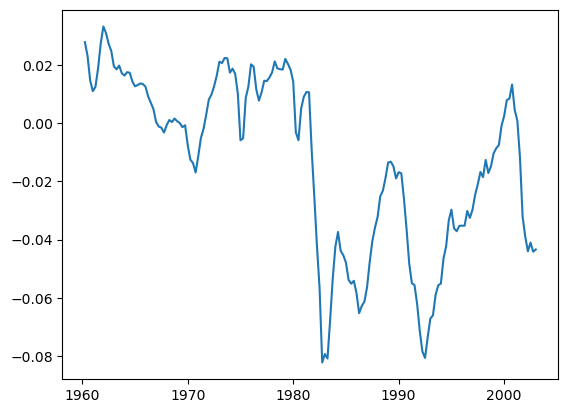

In [22]:
plt.plot(x_ax,V[fix:]) # Fed optimal policy variable

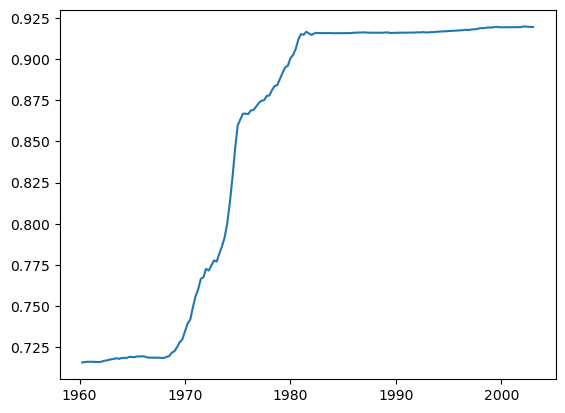

In [23]:
plt.plot(x_ax,(a1+a2)[fix:]) #Fed beliefs about persistence of inflation

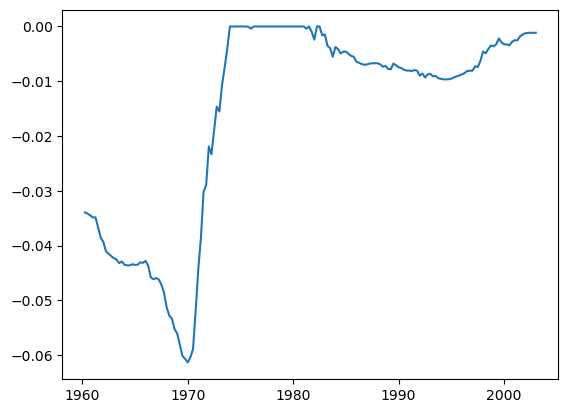

In [24]:
plt.plot(x_ax,(theta1+theta2)[fix:]) #Fed beliefs about slope of PC

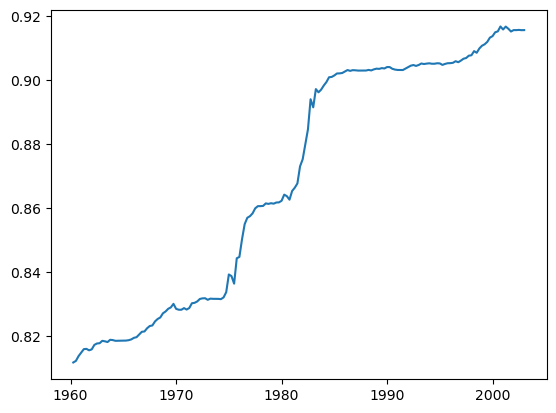

In [25]:
plt.plot(x_ax,(rho1+rho2)[fix:]) #Fed beliefs about persistence of unemployment rate

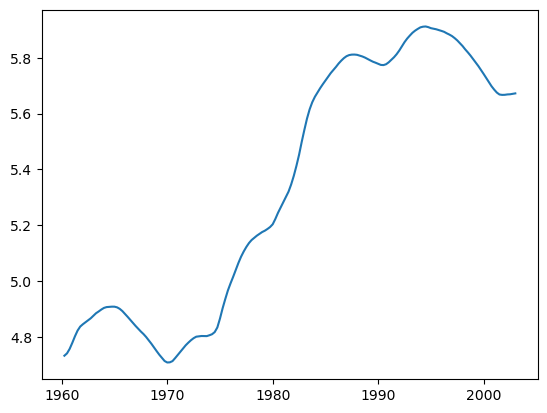

In [28]:
plt.plot(x_ax,(lru_smooth)[fix:]) #Fed beliefs about NAIRU (natural rate of unemployment)